In [6]:
import numpy as np
import os
import shutil
from pathlib import Path

In [9]:
root_annots_path = '/kaggle/input/dog-and-cat-detection/annotations/'
root_images_path = '/kaggle/input/dog-and-cat-detection/images/'

annots_path = sorted([i for i in Path(root_annots_path).glob('*.xml')])
images_path = sorted([i for i in Path(root_images_path).glob('*.png')])

n_imgs = len(images_path)

classes = np.array(["cat", "dog"])

In [10]:
with open(annots_path[500], 'r') as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>Cats_Test1448.png</filename>
    <size>
        <width>375</width>
        <height>500</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>dog</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>104</xmin>
            <ymin>78</ymin>
            <xmax>240</xmax>
            <ymax>250</ymax>
        </bndbox>
    </object>
</annotation>


## ImageAI
https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/Custom/CUSTOMDETECTIONTRAINING.md

In [2]:
!pip install imageai

     |████████████████████████████████| 160 kB 865 kB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 37.3 MB/s eta 0:00:01     |█████████████████▍              | 14.2 MB 27.2 MB/s eta 0:00:01     |████████████████████████████████| 26.0 MB 37.3 MB/s eta 0:00:01
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=41bc260e86614fa5dd95d25275bf554b6d989325d8b405a3be440f3df09a973d
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation

In [3]:
from imageai.Detection import ObjectDetection

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath('../input/gb-retinanet/resnet50_coco_best_v2.1.0.h5')
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image='../input/dog-and-cat-detection/images/Cats_Test1010.png',
                                             output_image_path='detected.png',
                                             minimum_percentage_probability=30)

for eachObject in detections:
    print(eachObject["name"] , " : ", eachObject["percentage_probability"], " : ", eachObject["box_points"] )
    print("--------------------------------")

cat  :  76.0070264339447  :  [25, 67, 192, 333]
--------------------------------
chair  :  50.68541169166565  :  [20, 49, 292, 487]
--------------------------------
couch  :  49.819597601890564  :  [20, 49, 292, 487]
--------------------------------
cat  :  48.170143365859985  :  [17, 107, 268, 474]
--------------------------------


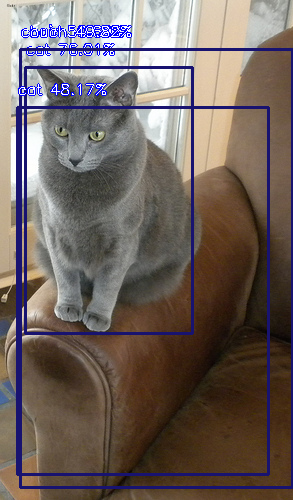

In [4]:
from PIL import Image
Image.open('detected.png')

### Preparing your custom dataset

In [7]:
os.makedirs('imageai/data/train/images', exist_ok=True)
os.makedirs('imageai/data/train/annotations', exist_ok=True)

os.makedirs('imageai/data/validation/images', exist_ok=True)
os.makedirs('imageai/data/validation/annotations', exist_ok=True)

os.makedirs('imageai/data/test/images', exist_ok=True)
os.makedirs('imageai/data/test/annotations', exist_ok=True)

In [11]:
n_imgs = 400
n_split = n_imgs // 20


for i, (annot_path, img_path) in enumerate(zip(annots_path, images_path)):    
    if i > n_imgs:
        break
    # train-val-test split
    if i < n_split:
        shutil.copy(img_path, 'imageai/data/test/images/' + img_path.parts[-1])
        shutil.copy(annot_path, 'imageai/data/test/annotations/' + annot_path.parts[-1])
    elif n_split <= i < n_split*5:
        shutil.copy(img_path, 'imageai/data/validation/images/' + img_path.parts[-1])
        shutil.copy(annot_path, 'imageai/data/validation/annotations/' + annot_path.parts[-1])
    else:
        shutil.copy(img_path, 'imageai/data/train/images/' + img_path.parts[-1])
        shutil.copy(annot_path, 'imageai/data/train/annotations/' + annot_path.parts[-1])

In [12]:
print(len(list(Path('imageai/data/train/annotations/').glob('*.xml'))))
print(len(list(Path('imageai/data/validation/annotations/').glob('*.xml'))))
print(len(list(Path('imageai/data/test/annotations/').glob('*.xml'))))

301
80
20


### Training on your custom dataset


In [13]:
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="./imageai/data/")
trainer.setTrainConfig(object_names_array=["cat", "dog"],
                       batch_size=8,
                       num_experiments=20,
                       train_from_pretrained_model="../input/gb-pretrainedyolov3h5/pretrained-yolov3.h5")
#                        train_from_pretrained_model="imageai/data/models/detection_model-ex-009--loss-0024.110.h5")

trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.81
Anchor Boxes generated.
Detection configuration saved in  ./imageai/data/json/detection_config.json
Evaluating over 80 samples taken from ./imageai/data/validation
Training over 301 samples  given at ./imageai/data/train
Training on: 	['cat', 'dog']
Training with Batch Size:  8
Number of Training Samples:  301
Number of Validation Samples:  80
Number of Experiments:  20
Training with transfer learning from pretrained Model


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/20
304/304 [==============================] - 179s 582ms/step - loss: 96.3344 - yolo_layer_loss: 11.8586 - yolo_layer_1_loss: 24.6192 - yolo_layer_2_loss: 48.2888 - val_loss: 46.3636 - val_yolo_layer_loss: 11.4201 - val_yolo_layer_1_loss: 10.2897 - val_yolo_layer_2_loss: 13.4275
Epoch 2/20
304/304 [==============================] - 175s 573ms/step - loss: 32.6105 - yolo_layer_loss: 3.6249 - yolo_layer_1_loss: 6.6402 - yolo_layer_2_loss: 11.9946 - val_loss: 36.6589 - val_yolo_layer_loss: 10.9631 - val_yolo_layer_1_loss: 7.0013 - val_yolo_layer_2_loss: 11.2440
Epoch 3/20
304/304 [==============================] - 177s 580ms/step - loss: 29.2801 - yolo_layer_loss: 4.2770 - yolo_layer_1_loss: 6.9079 - yolo_layer_2_loss: 11.3629 - val_loss: 30.2666 - val_yolo_layer_loss: 7.4734 - val_yolo_layer_1_loss: 6.8626 - val_yolo_layer_2_loss: 10.9601
Epoch 4/20
304/304 [==============================] - 179s 587ms/step - loss: 27.4633 - yolo_layer_loss: 4.6909 - yolo_layer_1_loss: 7.4878 - y

### Evaluating your saved detection models

In [15]:
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="./imageai/data/")
metrics = trainer.evaluateModel(model_path="imageai/data/models/detection_model-ex-020--loss-0017.844.h5",
                                json_path="imageai/data/json/detection_config.json",
                                iou_threshold=0.2,
                                object_threshold=0.3,
                                nms_threshold=0.5)

Starting Model evaluation....
Evaluating over 80 samples taken from ./imageai/data/validation
Training over 301 samples  given at ./imageai/data/train
Model File:  imageai/data/models/detection_model-ex-020--loss-0017.844.h5 

Evaluation samples:  80
Using IoU:  0.2
Using Object Threshold:  0.3
Using Non-Maximum Suppression:  0.5
cat: 0.4816
dog: 0.7081
mAP: 0.5948


https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/Custom/CUSTOMDETECTION.md

In [23]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("imageai/data/models/detection_model-ex-020--loss-0017.844.h5")
detector.setJsonPath("imageai/data/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(minimum_percentage_probability=50,
                                             input_image="imageai/data/validation/images/Cats_Test1015.png",
                                             output_image_path="detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

dog  :  56.16101622581482  :  [103, 37, 206, 143]


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


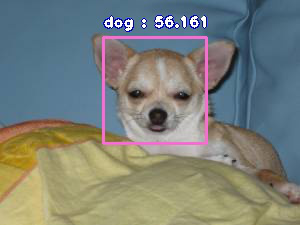

In [24]:
from PIL import Image
Image.open('detected.jpg')